# Measurement Incompatibility Testing

In [ ]:
# Make sure to load your IBM Q token before running the below block

In [11]:
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.ibmq.managed import IBMQJobManager

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

import matplotlib.pyplot as plt
import numpy as np

# custom code
import context
from device_independent_test import incompatible_measurement

ibmqfactory.load_account:WARNING:2020-06-25 13:41:58,859: Credentials are already in use. The existing account in the session will be replaced.


In [2]:
def bb84_states():
    # Alice's half of the circuit
    # creates 0,1,+,-
    qc = QuantumCircuit(4)
    qc.x(1) # create 1
    qc.h(2) # create +
    qc.x(3) # create -
    qc.h(3) # ^
    return qc

q_0: ──────────
     ┌───┐     
q_1: ┤ X ├─────
     ├───┤     
q_2: ┤ H ├─────
     ├───┤┌───┐
q_3: ┤ X ├┤ H ├
     └───┘└───┘

In [88]:
def measure_circuit(y):
    # Bob's measurement circuit
    # measure in either pi/4 or 3pi/4 basis
    qc = QuantumCircuit(4)
    theta = -1.0*(np.pi/4 + 0.5*y*np.pi)
    qc.u3(theta,0,0,range(0,4))
    #qc.u3(theta,0,0,1)
    #qc.u3(theta,0,0,2)
    #qc.u3(theta,0,0,3)
    qc.measure_all()
    return qc

In [89]:
qc = bb84_states() + measure_circuit(0)
qc.draw()

┌───────────────┐                                   ░ ┌─┐         
   q_0: ┤ U3(-pi/4,0,0) ├───────────────────────────────────░─┤M├─────────
        └─────┬───┬─────┘┌───────────────┐                  ░ └╥┘┌─┐      
   q_1: ──────┤ X ├──────┤ U3(-pi/4,0,0) ├──────────────────░──╫─┤M├──────
              ├───┤      ├───────────────┤                  ░  ║ └╥┘┌─┐   
   q_2: ──────┤ H ├──────┤ U3(-pi/4,0,0) ├──────────────────░──╫──╫─┤M├───
              ├───┤      └─────┬───┬─────┘┌───────────────┐ ░  ║  ║ └╥┘┌─┐
   q_3: ──────┤ X ├────────────┤ H ├──────┤ U3(-pi/4,0,0) ├─░──╫──╫──╫─┤M├
              └───┘            └───┘      └───────────────┘ ░  ║  ║  ║ └╥┘
meas_0: ═══════════════════════════════════════════════════════╩══╬══╬══╬═
                                                                  ║  ║  ║ 
meas_1: ══════════════════════════════════════════════════════════╩══╬══╬═
                                                                     ║  ║ 
meas_2: ═════════════════════════════════════════════════════════════╩══╬═
                                                                        ║ 
meas_3: ════════════════════════════════════════════════════════════════╩═

Job Status: job has successfully run


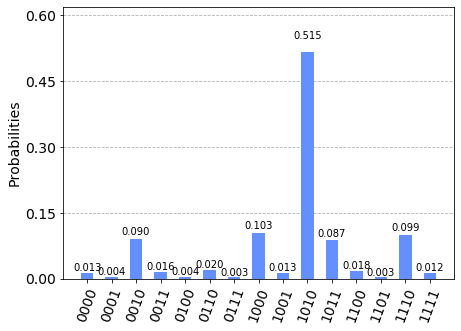

In [32]:
# OUTDATED CODE
# SEE CELL BELOW FOR BATCH JOB

from qiskit.tools.monitor import *
def run_job(qc):
    # runs test on all inputs
    # run cicuits in one batch
    #job_manager = IBMQJobManager()
    #job_set = job_manager.run([qc_0, qc_1], backend=provider.get_backend('ibmq_qasm_simulator'), name='msrincom_test')
    #job_monitor(job_set)
    #job_set.error_message()
    job = execute(qc, backend=provider.get_backend('ibmq_qasm_simulator'), shots=1000)
    job_monitor(job)
    return job
qc_0 = bb84_states() + measure_circuit(0)
job = run_job(qc_0)
job.result().get_counts(qc_0)
plot_histogram(job.result().get_counts(qc_0))


In [78]:
from qiskit.tools.monitor import *
def run_jobs(qc):
    # run cicuits in one batch
    job_manager = IBMQJobManager()
    job_set = job_manager.run(qc, backend=provider.get_backend('ibmq_qasm_simulator'), name='msrincom_test')
    job_set.error_messages()
    return job_set
qc_0 = bb84_states() + measure_circuit(0)
qc_1 = bb84_states() + measure_circuit(1)
managed_job = run_jobs([qc_0,qc_1])


In [83]:
result_0 = managed_job.job(0)[0].result()
result_1 = managed_job.job(1)[0].result()
#managed_job.job(0)[0].error_message()
result_0.get_counts(qc_0)

{'1011': 85,
 '0000': 17,
 '0001': 2,
 '1001': 23,
 '1111': 20,
 '1100': 18,
 '1010': 524,
 '0010': 104,
 '0100': 4,
 '0111': 3,
 '1101': 4,
 '0110': 10,
 '1110': 94,
 '1000': 105,
 '0011': 11}

Job Status: job has successfully run


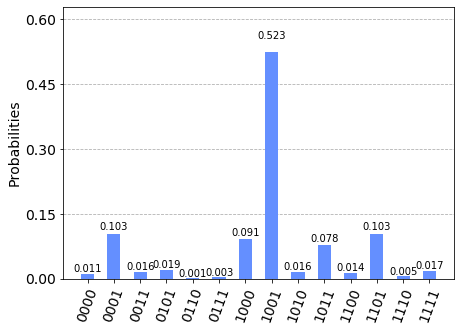

In [33]:
qc_1 = bb84_states() + measure_circuit(1)
job2 = run_job(qc_1)
job2.result().get_counts(qc_1)
plot_histogram(job2.result().get_counts(qc_1))

In [61]:
counts = job2.result().get_counts(qc_1)
print(counts)

# 2x4 matrix for probabilities
# row for x
# column for y
bins = (2,4)
bins = np.zeros(bins)

# iterate over dictionary
for state in counts:
    for i in range(0,4):
        r = int(state[i])
        c = 3 - i
        bins[r,c] += counts[state]
print(bins)
# convert bins to probibilities
probs = bins / 1000.0
print(probs)

{'1011': 78, '0000': 11, '0001': 103, '1001': 523, '1111': 17, '1100': 14, '0101': 19, '1010': 16, '0111': 3, '1101': 103, '0110': 1, '1110': 5, '1000': 91, '0011': 16}
[[138. 864. 838. 153.]
 [862. 136. 162. 847.]]
[[0.138 0.864 0.838 0.153]
 [0.862 0.136 0.162 0.847]]
